This notebook has the goal of testing MFA-models, and determining if it is a good model choice. 
The notebook aims to test:
-   Model Complexity - Will the model be able to get a good BIC score and out-of-sample likelyhood
-   Reconstruction Fidelity - Calculate the reconstruction error in RMSE and SAM (Spectral Angle Mapper)
-   Interpretability - Does the components represent different and new signals
-   Class Interpretability - Assign a colour to each FA, and map the Hyperspectral image next to its rgb-image, do we see the same structures?  

In [1]:
import torch
import glob
import numpy as np
import matplotlib.pyplot as plt
from hypso import Hypso
from MFA import MFA
import os
from utils import calculate_rmse, calculate_sam

# Settings
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


Loading the models, this includes the training statistics

In [2]:
data_product = 'l1b'

In [ ]:
# Load PCA
pca_checkpoint = torch.load(f'models/pca_benchmark_{data_product}.pt', map_location=device)
pca_components = pca_checkpoint['components'].to(device)
pca_mean = pca_checkpoint['mean'].to(device)

# Load MFA
mfa_checkpoint = torch.load(f'models/mfa_k8_q_{data_product}.pt', map_location=device)
mfa_hyperparams = mfa_checkpoint['hyperparameters']

mfa_model = MFA(
    n_components=mfa_hyperparams['n_components'],
    n_features=mfa_hyperparams['n_features'],
    n_factors=mfa_hyperparams['n_factors'],
    device=device
)
mfa_model.load_state_dict(mfa_checkpoint['model_state_dict'])

# Extract MFA Preprocessing Stats
mfa_stats = mfa_checkpoint['preprocessing']
mfa_data_max = mfa_stats['data_max'].to(device)
mfa_data_mean = mfa_stats['mean'].to(device)

print("Models loaded successfully.")
print(f"MFA Config: K={mfa_hyperparams['n_components']}, q={mfa_hyperparams['n_factors']}")

Models loaded successfully.
MFA Config: K=8, q=7


Loading data, note that the models have differnet preprocessing steps

In [ ]:
data_dir = glob.glob(f'data/testing_{data_product}/*.nc')
print(f"Found {len(data_dir)} files.")

target_total_samples = 6000
samples_per_file = target_total_samples // len(data_dir) 
sampled_data_list = []

print(f"Aiming to extract ~{samples_per_file} pixels per file.")

for file in data_dir:
    # Load Data
    try:
        satobj = Hypso(file) 
        if satobj is None: continue
        
        # Load and reshape
        match data_product:
            case 'l1a':
                data = satobj.l1a_cube.values.astype(np.float32)
            case 'l1b':
                data = satobj.l1b_cube.values.astype(np.float32)
            case 'l1d':
                data = satobj.l1d_cube.values.astype(np.float32)
            case _:
                raise ValueError(f"Unknown data product: {data_product}")
            
        h, w, b = data.shape
        data_2d = data.reshape(-1, b) # Shape: (Total_Pixels_In_Image, 120)
        
        # Random Subsampling 
        total_pixels_in_image = data_2d.shape[0]
        
        # Determine how many to take (don't take more than exists)
        n_to_take = min(samples_per_file, total_pixels_in_image)
        
        # Generate random indices
        rng = np.random.default_rng()
        indices = rng.choice(total_pixels_in_image, size=n_to_take, replace=False)
        
        # Grab the random pixels and add to list
        sampled_pixel_subset = data_2d[indices, :]
        sampled_data_list.append(sampled_pixel_subset)
        
        print(f"File: {os.path.basename(file)} | Extracted {n_to_take} pixels.")

    except Exception as e:
        print(f"Error processing {file}: {e}")

# Final Concatenation
if sampled_data_list:
    flat_data = np.concatenate(sampled_data_list, axis=0)
    flat_data = torch.tensor(flat_data, dtype=torch.float32).to(device)

    print("-" * 30)
    print(f"Final Analysis Dataset Shape: {flat_data.shape}")
else:
    print("No data loaded.")

Found 8 files.
Aiming to extract ~750 pixels per file.
File: gulfofcampeche_2024-05-17T15-49-37Z-l1b.nc | Extracted 750 pixels.
File: lacrau_2025-01-17T09-40-10Z-l1b.nc | Extracted 750 pixels.
File: lakevolta_2023-01-19T09-40-06Z-l1b.nc | Extracted 750 pixels.
File: mwanza_2022-07-21T07-43-03Z-l1b.nc | Extracted 750 pixels.
File: princeWilliam_2022-12-09T19-57-47Z-l1b.nc | Extracted 750 pixels.
File: svalbard_2022-07-31T11-43-59Z-l1b.nc | Extracted 750 pixels.
File: uijsselmeer_2024-10-22T09-53-08Z-l1b.nc | Extracted 750 pixels.
File: wildfirePerth_2025-03-17T01-54-12Z-l1b.nc | Extracted 750 pixels.
------------------------------
Final Analysis Dataset Shape: torch.Size([6000, 120])


In [ ]:
# Helper to load and preprocess a single file
def load_and_preprocess(flat_data, model_type='mfa', mfa_stats=None, pca_mean=None, device='cpu'):

    if model_type == 'mfa':
        # Scale 0-1 then center, using TRAINING stats
        scaled = flat_data / mfa_stats['data_max']
        processed = scaled - mfa_stats['mean']
    elif model_type == 'pca':
        # Just center using TRAINING mean
        processed = flat_data - pca_mean
        
    return processed

# Search for test files (adjust path as needed)
test_files = glob.glob(f'data/testing_{data_product}/*.nc')
if not test_files:
    # Fallback if no testing folder exists, use a training file for demo purposes
    print("Warning: No test files found in data/testing. Using training data for demonstration.")
    test_files = glob.glob('data/training/*.nc')

# Merging the test-files into one file for testing

current_file = test_files[0]
print(f"Testing on: {current_file}")


# Load versions for both models
X_test_mfa = load_and_preprocess(flat_data, 'mfa', mfa_stats=mfa_stats, device=device)
X_test_pca = load_and_preprocess(flat_data, 'pca', pca_mean=pca_mean, device=device)

Testing on: data/testing_l1b\gulfofcampeche_2024-05-17T15-49-37Z-l1b.nc


### Reconstruction Logic

In [6]:
# --- PCA Reconstruction ---
# Encode
z_pca = torch.matmul(X_test_pca, pca_components)
# Decode
X_rec_pca_centered = torch.matmul(z_pca, pca_components.T)
# De-process (Add mean)
X_rec_pca_final = X_rec_pca_centered + pca_mean

# --- MFA Reconstruction ---
def reconstruct_mfa(model, X):
    """
    Reconstructs X using the Component-Specific posterior expectation.
    """
    # Get Responsibilities (Gamma) and local projections
    with torch.no_grad():
        # FIX 1: Swap variables. e_step returns (responsibilities, likelihood)
        log_resp, log_prob = model.e_step(X) 
        
        responsibilities = torch.exp(log_resp) 
        
        # Get cluster assignments
        cluster_ids = torch.argmax(responsibilities, dim=1)
        
        X_rec = torch.zeros_like(X)
        
        # FIX 2: Use model.K instead of model.n_components
        for k in range(model.K):
            # Indices belonging to cluster k
            mask = (cluster_ids == k)
            if mask.sum() == 0: continue
            
            X_k = X[mask]
            
            # Centered data for this component
            X_k_centered = X_k - model.mu[k]
            
            # FIX 3: Use model.Lambda instead of model.W
            Lambda = model.Lambda[k] 
            
            Psi_inv = torch.diag(1.0 / torch.exp(model.log_psi)) 
            
            # FIX 4: Use model.q instead of model.n_factors
            # Beta calc: beta = (I + L.T @ Psi_inv @ L)^-1 @ L.T @ Psi_inv
            M = torch.inverse(torch.eye(model.q, device=device) + Lambda.T @ Psi_inv @ Lambda)
            beta = M @ Lambda.T @ Psi_inv
            
            z_k = (X_k_centered @ beta.T)
            
            # Reconstruct
            X_rec_k = z_k @ Lambda.T + model.mu[k]
            X_rec[mask] = X_rec_k
            
    return X_rec, cluster_ids

# Run the fixed function
X_rec_mfa_processed, cluster_ids = reconstruct_mfa(mfa_model, X_test_mfa)

# De-process MFA (Add mean -> Scale back)
X_rec_mfa_final = (X_rec_mfa_processed + mfa_stats['mean']) * mfa_stats['data_max']

In [7]:
# Calculate Scores
rmse_pca = calculate_rmse(X_test_pca, X_rec_pca_final)
sam_pca = calculate_sam(X_test_pca, X_rec_pca_final)

rmse_mfa = calculate_rmse(X_test_mfa, X_rec_mfa_final)
sam_mfa = calculate_sam(X_test_mfa, X_rec_mfa_final)

print("=== Reconstruction Benchmark Results ===")
print(f"PCA (q={pca_components.shape[1]}): RMSE = {rmse_pca:.4f}, SAM = {sam_pca:.4f} rad")
print(f"MFA (K={mfa_model.K}, q={mfa_model.q}): RMSE = {rmse_mfa:.4f}, SAM = {sam_mfa:.4f} rad")
print("========================================")

=== Reconstruction Benchmark Results ===
PCA (q=5): RMSE = 65.5524, SAM = 1.7779 rad
MFA (K=8, q=7): RMSE = 21328.7676, SAM = 1.7705 rad


### Class segmentation test

Image Shape: 956x684 with 120 bands


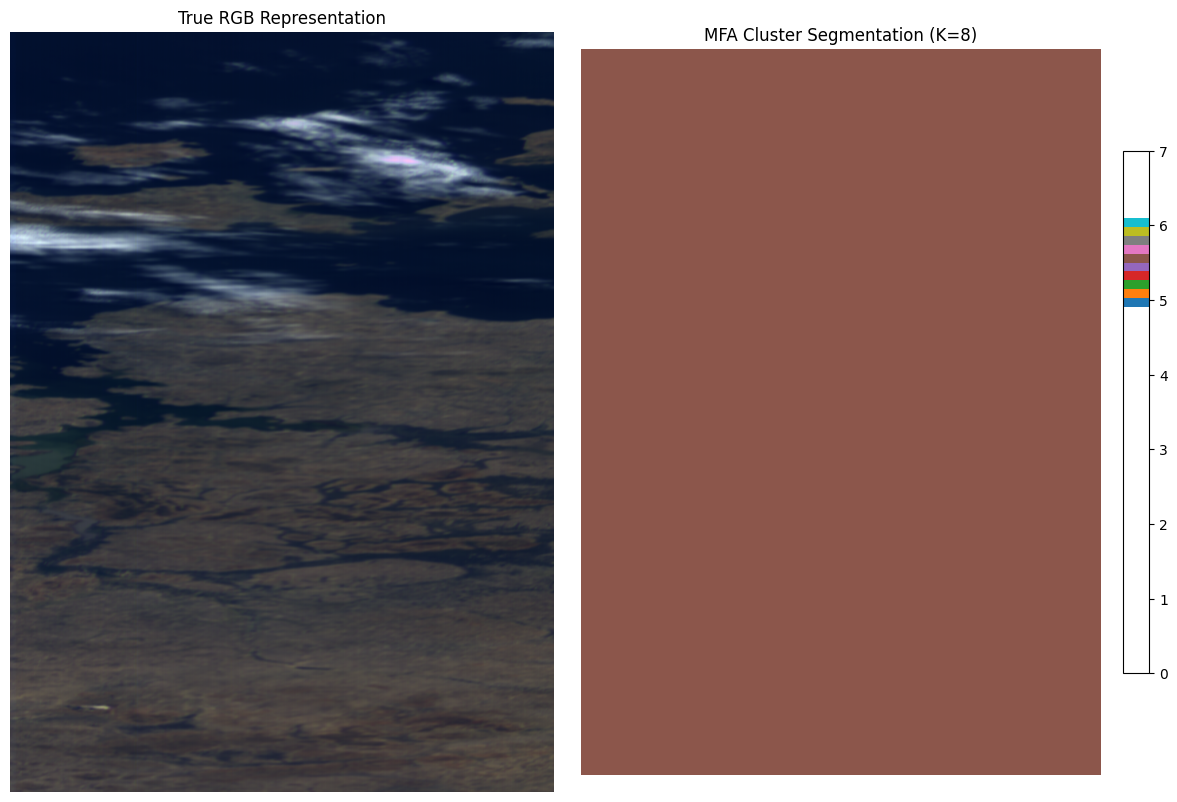

In [8]:
# Reshape clusters to image
file_testing = f'data/testing_{data_product}/mwanza_2022-07-21T07-43-03Z-l1{data_product[-1]}.nc'

satobj = Hypso(file_testing) 

# 1. Load the full image data
match data_product:
    case 'l1a':
        data = satobj.l1a_cube.values.astype(np.float32)
    case 'l1b':
        data = satobj.l1b_cube.values.astype(np.float32)
    case 'l1d':
        data = satobj.l1d_cube.values.astype(np.float32)
    case _:
        raise ValueError(f"Unknown data product: {data_product}")

h, w, b = data.shape
print(f"Image Shape: {h}x{w} with {b} bands")

# Flatten the full image for the model
data_2d_full = data.reshape(-1, b) # Shape: (Total_Pixels_In_Image, 120)

# 2. Preprocess the full image (CRITICAL STEP)
# We must use the same stats we used for the random test set
data_2d_full_tensor = torch.tensor(data_2d_full, dtype=torch.float32).to(device)
X_full_mfa = (data_2d_full_tensor / mfa_stats['data_max']) - mfa_stats['mean']

# 3. Run Inference to get NEW cluster_ids for this specific image
with torch.no_grad():
    # We only need the responsibilities to get the argmax (cluster id)
    log_resp, _ = mfa_model.e_step(X_full_mfa)
    responsibilities = torch.exp(log_resp)
    new_cluster_ids = torch.argmax(responsibilities, dim=1)

# 4. NOW reshape the new IDs
seg_map = new_cluster_ids.reshape(h, w).cpu().numpy()

# Get RGB for comparison (Bands 70, 50, 20 approx for Hypso)
rgb_bands = [70, 50, 20]
rgb_img = data[:, :, rgb_bands]
# Normalize RGB for display
rgb_img = (rgb_img - np.min(rgb_img)) / (np.max(rgb_img) - np.min(rgb_img))

fig, ax = plt.subplots(1, 2, figsize=(12, 8))

# 2. Plot True RGB
# aspect='equal' ensures 1 pixel is square (fixes the squashing)
ax[0].imshow(rgb_img, aspect='equal') 
ax[0].set_title("True RGB Representation")
ax[0].axis('off')

# 3. Plot Segmentation Map using imshow instead of heatmap
# cmap='tab10': Good distinct colors for categorical data
# interpolation='nearest': Keeps edges sharp (no blurring between classes)
# aspect='equal': Matches the geometry of the RGB image exactly
# vmax=K: Ensures the colormap covers the correct range of clusters
im = ax[1].imshow(seg_map, cmap='tab10', interpolation='nearest', aspect='equal')
ax[1].set_title(f"MFA Cluster Segmentation (K={mfa_model.K})")
ax[1].axis('off')

# Optional: Add a legend for the clusters
# This creates a colorbar with discrete ticks for each cluster
cbar = plt.colorbar(im, ax=ax[1], fraction=0.046, pad=0.04)
cbar.set_ticks(np.arange(mfa_model.K) + 0.5) # Center ticks on color block
cbar.set_ticklabels(np.arange(mfa_model.K))  # Label as 0, 1, 2...

plt.tight_layout()
plt.show()

### Spectral Components

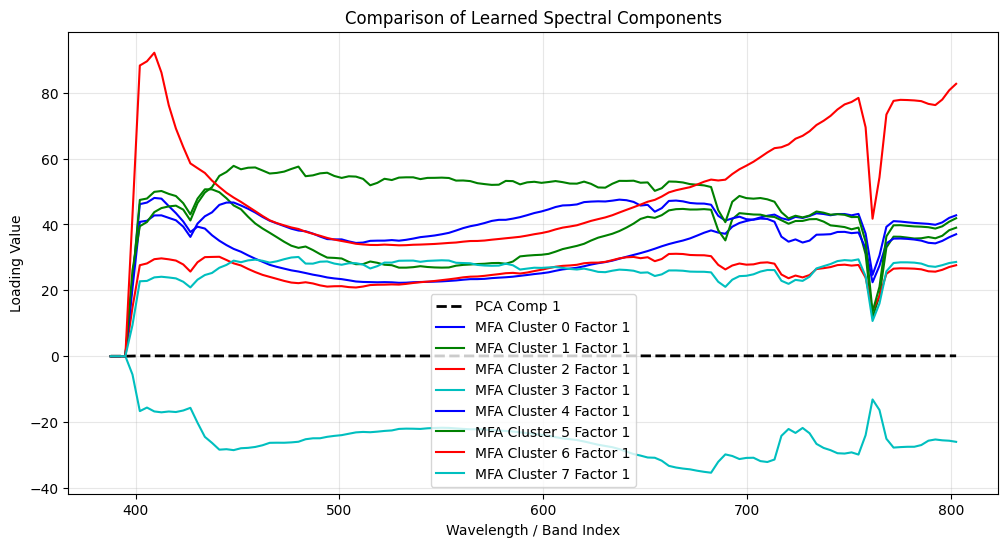

In [9]:
wavelengths = satobj.wavelengths if hasattr(satobj, 'wavelengths') else np.arange(120)

plt.figure(figsize=(12, 6))

# Plot PCA First Component
plt.plot(wavelengths, pca_components[:, 0].cpu().numpy(), 'k--', label='PCA Comp 1', linewidth=2)

# Plot MFA Component 1 for each cluster
colors = ['b', 'g', 'r', 'c']
for k in range(mfa_model.K):
    # Extract Factor Loading Matrix (Lambda) for cluster k
    # Shape (D, q), we take first factor
    loading = mfa_model.Lambda[k][:, 0].detach().cpu().numpy()
    plt.plot(wavelengths, loading, label=f'MFA Cluster {k} Factor 1', color=colors[k % len(colors)])

plt.xlabel("Wavelength / Band Index")
plt.ylabel("Loading Value")
plt.title("Comparison of Learned Spectral Components")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

Scatterplot of the points assigned to MFA cluster 0 and MFA cluster 1

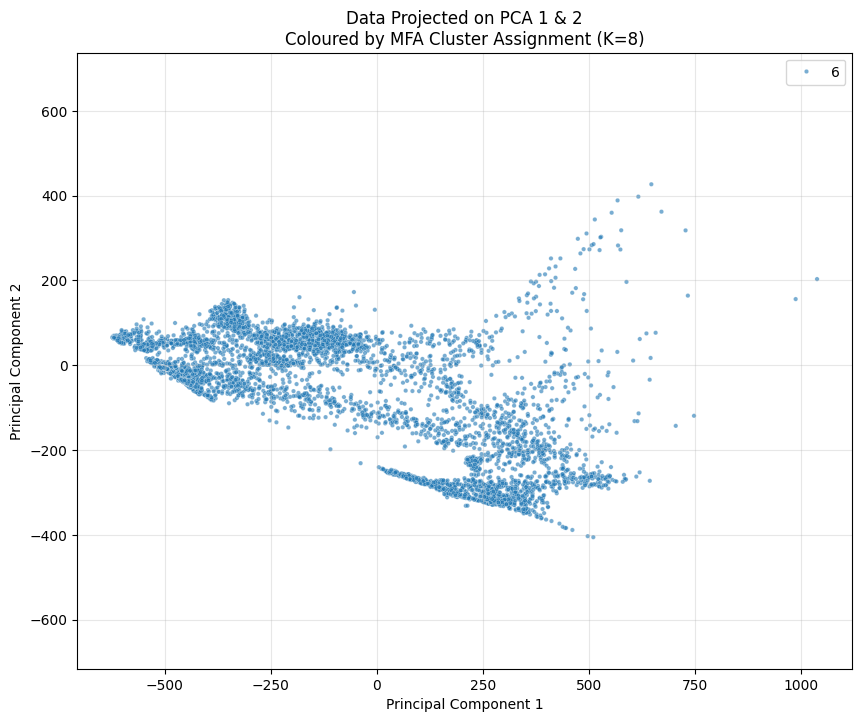

In [10]:
import torch
import matplotlib.pyplot as plt
import seaborn as sns

# Ensure we are in no_grad mode for inference
with torch.no_grad():
    # ---------------------------------------------------------
    # 1. PREPARE DATA
    # ---------------------------------------------------------
    # Ensure you are using the correct preprocessing for each model!
    # PCA expects: (X - pca_mean)
    # MFA expects: (X / data_max) - mfa_mean
    
    # We assume 'flat_data' contains your raw spectral pixels (N, bands)
    
    # Preprocess for PCA
    X_for_pca = flat_data - pca_mean
    
    # Preprocess for MFA
    X_for_mfa = (flat_data / mfa_stats['data_max']) - mfa_stats['mean']

    # ---------------------------------------------------------
    # 2. COMPUTE PROJECTIONS AND ASSIGNMENTS
    # ---------------------------------------------------------
    
    # A) Project onto PCA components (Global View)
    # shape: (N, n_components)
    z_pca = torch.matmul(X_for_pca, pca_components)
    
    # Extract just PC1 and PC2 for plotting
    pc1 = z_pca[:, 0].cpu().numpy()
    pc2 = z_pca[:, 1].cpu().numpy()

    # B) Get MFA Cluster Assignments (Local View)
    # e_step returns log probabilities, we exp them to get responsibilities (gamma)
    log_resp, _ = mfa_model.e_step(X_for_mfa)
    responsibilities = torch.exp(log_resp)
    
    # Assign each pixel to the cluster with the highest responsibility
    cluster_ids = torch.argmax(responsibilities, dim=1).cpu().numpy()

    # ---------------------------------------------------------
    # 3. VISUALIZATION
    # ---------------------------------------------------------
    plt.figure(figsize=(10, 8))
    plt.axis('equal') 

    
    # Use seaborn for easy coloring by category
    sns.scatterplot(
        x=pc1, 
        y=pc2, 
        hue=cluster_ids, 
        palette='tab10',  # Distinct colors for clusters
        s=10,             # Marker size
        alpha=0.6,        # Transparency to see density
        legend='full'
    )
    
    plt.title(f"Data Projected on PCA 1 & 2\nColoured by MFA Cluster Assignment (K={mfa_model.K})")
    plt.xlabel("Principal Component 1")
    plt.ylabel("Principal Component 2")
    plt.grid(True, alpha=0.3)
    plt.show()

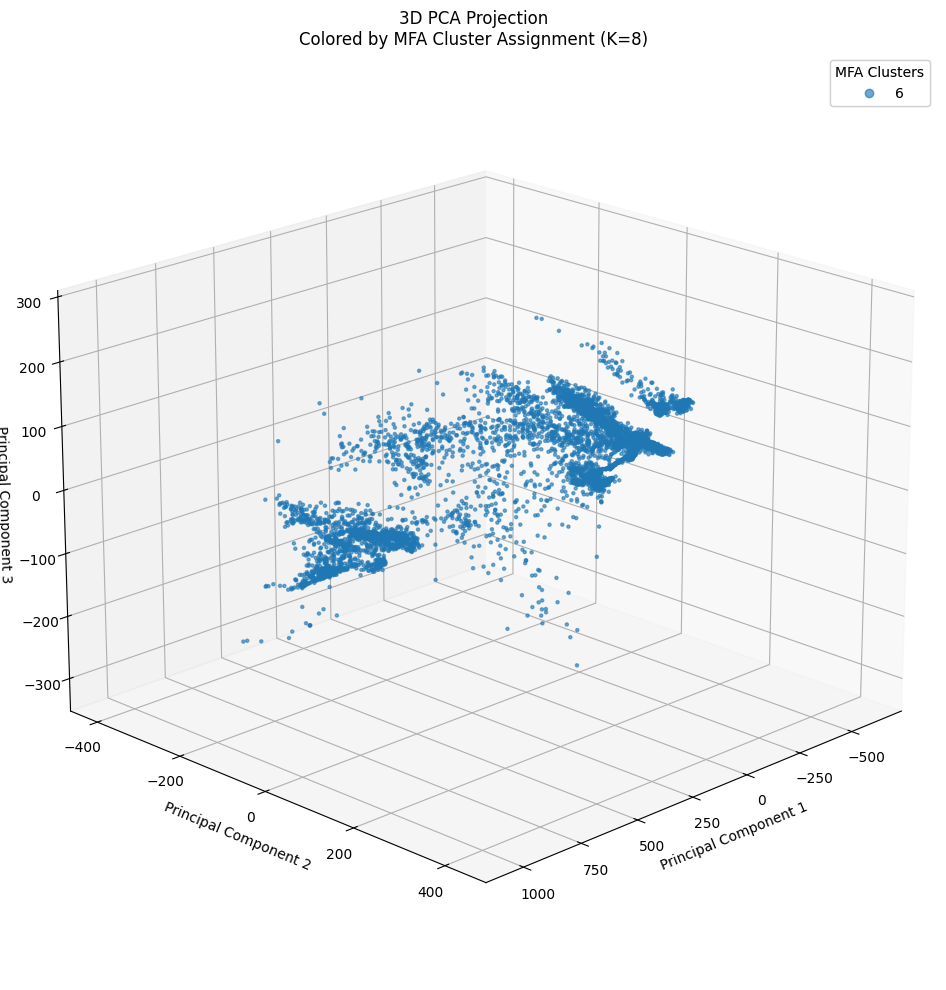

In [11]:
import torch
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # Register 3D projection
import numpy as np

# Ensure we are in no_grad mode
with torch.no_grad():
    # ---------------------------------------------------------
    # 1. PREPARE DATA
    # ---------------------------------------------------------
    # Assuming 'flat_data', 'pca_mean', 'mfa_stats', 'pca_components', and 'mfa_model' 
    # are already loaded in your environment from the previous steps.

    # Preprocess for PCA (Center the data)
    X_for_pca = flat_data - pca_mean
    
    # Preprocess for MFA (Scale and Center using MFA stats)
    X_for_mfa = (flat_data / mfa_stats['data_max']) - mfa_stats['mean']

    # ---------------------------------------------------------
    # 2. COMPUTE 3D PROJECTIONS AND ASSIGNMENTS
    # ---------------------------------------------------------
    
    # A) Project onto PCA components
    # Check if we have enough components
    if pca_components.shape[1] < 3:
        print(f"Warning: PCA matrix only has {pca_components.shape[1]} components. Cannot plot 3D.")
    else:
        # Project to latent space (N, n_components)
        z_pca = torch.matmul(X_for_pca, pca_components)
        
        # Extract first 3 Principal Components
        pc1 = z_pca[:, 0].cpu().numpy()
        pc2 = z_pca[:, 1].cpu().numpy()
        pc3 = z_pca[:, 2].cpu().numpy()

        # B) Get MFA Cluster Assignments
        # e_step returns log probabilities; exp() gives us responsibilities (gamma)
        log_resp, _ = mfa_model.e_step(X_for_mfa)
        responsibilities = torch.exp(log_resp)
        
        # Assign pixel to the cluster with the highest responsibility
        cluster_ids = torch.argmax(responsibilities, dim=1).cpu().numpy()

        # ---------------------------------------------------------
        # 3. 3D VISUALIZATION
        # ---------------------------------------------------------
        fig = plt.figure(figsize=(12, 10))
        ax = fig.add_subplot(111, projection='3d')
        
        # Create the scatter plot
        scatter = ax.scatter(
            pc1, pc2, pc3,
            c=cluster_ids,       # Color by MFA cluster
            cmap='tab10',        # Discrete color map
            s=5,                 # Small marker size for density
            alpha=0.6,            # Transparency
        )
        
        # Add a legend
        legend = ax.legend(*scatter.legend_elements(), title="MFA Clusters")
        ax.add_artist(legend)

        # Labels and Title
        ax.set_xlabel('Principal Component 1')
        ax.set_ylabel('Principal Component 2')
        ax.set_zlabel('Principal Component 3')
        ax.set_title(f"3D PCA Projection\nColored by MFA Cluster Assignment (K={mfa_model.K})")
        
        # Optional: Adjust initial view angle (elevation, azimuth)
        ax.view_init(elev=20, azim=45)
        
        plt.tight_layout()
        plt.show()